## Loading Libraries

In [ ]:
%matplotlib inline

import torch.nn as nn
import pandas as pd
import numpy as np
import keras
from keras import layers
import tensorflow as tf
from sklearn.model_selection import train_test_split
import collections

In [ ]:
path = 'drive/MyDrive/ADM/movielens/'

## Loading Datasets

In [ ]:
ratings = pd.read_csv(path + "ratings.csv")

In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2,3.5,1112486027
1,1,29,3.5,1112484676
2,1,32,3.5,1112484819
3,1,47,3.5,1112484727
4,1,50,3.5,1112484580


In [ ]:
print(f"full dataset:\nnumber users {int(ratings.userId.nunique())}, number movies {int(ratings.movieId.nunique())}")

full dataset:
number users 138493, number movies 26744


In [ ]:
u_uniq = ratings.userId.unique()
user2idx = {o:i for i,o in enumerate(u_uniq)}
ratings.userId = ratings.userId.apply(lambda x: user2idx[x])

m_uniq = ratings.movieId.unique()
movie2idx = {o:i for i,o in enumerate(m_uniq)}
ratings.movieId = ratings.movieId.apply(lambda x: movie2idx[x])

In [ ]:
n_users=int(ratings.userId.nunique())
n_movies=int(ratings.movieId.nunique())
print(f"number users: {n_users}, number movies {n_movies}")

number users: 138493, number movies 26744


## Preprocessing

In [ ]:
train, test = train_test_split(ratings, test_size=0.1)

In [ ]:
train.shape

(18000236, 4)

In [ ]:
x_train = train.drop(['rating', 'timestamp'],axis=1)
y_train = train['rating'].astype(np.float32)
print(x_train.shape)
print(y_train)

(18000236, 2)
13602835    5.0
8087075     4.0
18705292    4.0
14338071    3.5
14176156    3.0
           ... 
8764597     2.0
13544748    4.0
1888215     4.0
12777994    2.0
15894294    4.0
Name: rating, Length: 18000236, dtype: float32


In [ ]:
x_test = test.drop(['rating', 'timestamp'],axis=1)
y_test = test['rating'].astype(np.float32)
print(x_test)
print(y_test)

          userId  movieId
11152047   77020     1406
13320321   92023      182
14920229  103084     2230
14964207  103335     1270
3322387    22695       77
...          ...      ...
3048677    20759      396
13371594   92421        3
19705671  136438     1004
6000872    41315     2406
8399773    57968      535

[2000027 rows x 2 columns]
11152047    5.0
13320321    3.0
14920229    3.0
14964207    5.0
3322387     2.0
           ... 
3048677     4.0
13371594    3.5
19705671    4.0
6000872     2.5
8399773     2.0
Name: rating, Length: 2000027, dtype: float32


In [ ]:
x_train_sample = x_train[400000:900000]
y_train_sample = y_train[400000:900000]
x_train_sample.shape

(500000, 2)

In [ ]:
UNIQUE_MOVIE_IDS = ratings['movieId'].unique()
UNIQUE_USER_IDS = ratings['userId'].unique()

In [ ]:
ROW_COUNT = x_train_sample.shape[0]
ROW_COUNT

500000

In [ ]:
EMBEDDING_SIZE = 100
NUM_USERS = n_users
NUM_MOVIES = n_movies

## Model Definition

In [ ]:
def EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT):
    movie_input = keras.Input(shape=(1,), name='movie_id')

    movie_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_MOVIES, input_length=ROW_COUNT, name='movie_emb')(movie_input)
    movie_vec = layers.Flatten(name='FlattenMovie')(movie_emb)

    movie_model = keras.Model(inputs=movie_input, outputs=movie_vec)
    
    user_input = keras.Input(shape=(1,), name='user_id')

    user_emb = layers.Embedding(output_dim=EMBEDDING_SIZE, input_dim=NUM_USERS, input_length=ROW_COUNT, name='user_emb')(user_input)
    user_vec = layers.Flatten(name='FlattenUser')(user_emb)

    user_model = keras.Model(inputs=user_input, outputs=user_vec)
    
    merged = layers.Dot(name = 'dot_product', normalize = True, axes = 2)([movie_emb, user_emb])
    merged_dropout = layers.Dropout(0.2)(merged)
    
    
    dense_1 = layers.Dense(150,name='FullyConnected-1')(merged)
    dropout_1 = layers.Dropout(0.2,name='Dropout_1')(dense_1)

    dense_2 = layers.Dense(50,name='FullyConnected-2')(dropout_1)
    dropout_2 = layers.Dropout(0.1,name='Dropout_2')(dense_2)

    result = layers.Dense(1, name='result', activation="sigmoid") (dropout_2)

    adam = tf.keras.optimizers.Adam(learning_rate=0.01)
    model = keras.Model([movie_input, user_input], result)
    model.compile(optimizer=adam,loss= 'mean_squared_error')
    return model, movie_model, user_model

In [ ]:
model, movie_model, user_model = EmbeddingRec(EMBEDDING_SIZE, NUM_MOVIES, NUM_USERS, ROW_COUNT)

In [ ]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
movie_id (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
user_id (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
movie_emb (Embedding)           (None, 1, 100)       2674400     movie_id[0][0]                   
__________________________________________________________________________________________________
user_emb (Embedding)            (None, 1, 100)       13849300    user_id[0][0]                    
____________________________________________________________________________________________

In [ ]:
from keras.models import load_model
model = load_model(path + 'besttest.h5')

## Training

In [ ]:
callbacks = [tf.keras.callbacks.EarlyStopping('val_loss', patience=2),
             tf.keras.callbacks.ModelCheckpoint(path + 'besttest.h5', save_best_only=True)]

history = model.fit([x_train_sample.movieId, x_train_sample.userId],y_train_sample, batch_size=100,
                              epochs =50, validation_data=([x_test.movieId, x_test.userId], y_test),
                              verbose = 1, 
                              callbacks = callbacks)

Epoch 1/50
5000/5000 [==============================] - 955s 191ms/step - loss: 7.4794 - val_loss: 7.4903
Epoch 2/50
5000/5000 [==============================] - 892s 178ms/step - loss: 7.4794 - val_loss: 7.4903
Epoch 3/50
5000/5000 [==============================] - 917s 183ms/step - loss: 7.4794 - val_loss: 7.4903


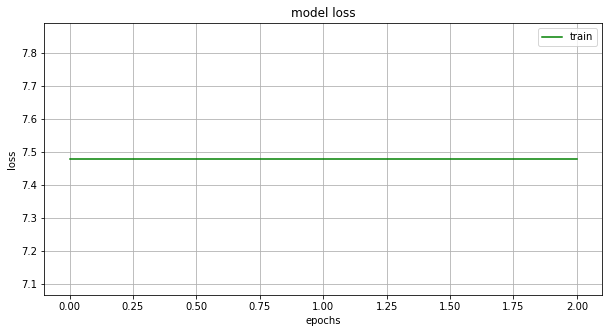

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 10, 5
import matplotlib.pyplot as plt
plt.plot(history.history['loss'] , 'g')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epochs')
plt.legend(['train'], loc='upper right')
plt.grid(True)
plt.show()

In [ ]:
MOVIE_EMBEDDING_LIST = []
MOIVE_RATINGS_PRED = []
MOVIE_EMBED_MAP = collections.defaultdict()

In [ ]:
print(UNIQUE_MOVIE_IDS.shape)
print(UNIQUE_USER_IDS.shape)

(26744,)
(138493,)


In [ ]:
for _id in UNIQUE_MOVIE_IDS:
    emb = movie_model.predict(np.array([_id]))
    val = list(emb.reshape(1,-1))[0]
    MOVIE_EMBEDDING_LIST.insert(_id, val)
    MOVIE_EMBED_MAP[_id] = val

KeyboardInterrupt: ignored

In [ ]:
len(MOVIE_EMBEDDING_LIST)

In [ ]:
temp = np.array([[mid, uid]])
temp = np.append(temp, [mid, uid])
temp = np.append(temp, [mid, uid])
temp = np.append(temp, [mid, uid])
temp.shape

(8,)

In [ ]:
MOIVE_RATINGS_PRED = pd.DataFrame(columns=['movieId', 'userId', 'rating'])

In [ ]:
for uid in UNIQUE_USER_IDS:
  for mid in UNIQUE_MOVIE_IDS:
    _inpu = [np.array([2259]), np.array([1])]
    rating_pred = model.predict(_inpu)
    val = rating_pred.reshape(1, -1)[0][0]
    MOIVE_RATINGS_PRED = MOIVE_RATINGS_PRED.append({'movieId' : mid, 'userId' : uid, 'rating' : val}, ignore_index=True)

KeyboardInterrupt: ignored

In [ ]:
MOIVE_RATINGS_PRED.head(200)

,movieId,userId,rating
0,0.0,0.0,1.0
1,0.0,0.0,1.0
2,1.0,0.0,1.0
3,2.0,0.0,1.0
4,3.0,0.0,1.0
...,...,...,...
195,194.0,0.0,1.0
196,195.0,0.0,1.0
197,196.0,0.0,1.0
198,197.0,0.0,1.0


In [ ]:
DF = pd.DataFrame(MOVIE_EMBEDDING_LIST)
DF.to_pickle(path + 'movie_embeddings_1.pkl')

In [ ]:
DF

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
0,-0.029365,-0.029352,-0.031192,-0.011644,-0.017321,0.027635,-0.048266,-0.014380,0.024477,0.048038,0.015033,-0.032807,-0.015022,-0.041547,0.009819,0.026248,0.022276,0.005479,0.039941,-0.029774,-0.048435,0.019073,0.013811,-0.019916,-0.018471,-0.033017,0.023823,-0.019553,0.014853,0.019132,-0.029028,-0.020750,-0.008621,-0.044085,0.042407,-0.038400,-0.033289,-0.031650,0.045687,0.005980,...,0.013923,0.036151,0.010546,0.036429,-0.002848,-0.010380,0.003970,0.021355,0.001329,0.027800,0.030653,-0.022809,-0.049498,0.004946,-0.024860,-0.046659,-0.041230,0.022374,-0.038307,-0.004580,0.020825,-0.025359,-0.033808,-0.001806,0.043326,0.023161,-0.041311,-0.040592,0.002877,-0.001685,-0.049403,-0.029768,-0.023093,-0.001951,-0.024746,0.039837,-0.048239,0.008592,-0.008328,-0.003379
1,0.017979,0.021861,-0.020371,0.034225,-0.018364,-0.015082,0.013061,-0.022779,0.046697,0.033575,-0.011691,0.015646,-0.025193,0.018183,0.039227,-0.013348,-0.023918,-0.048387,0.006869,0.041083,-0.033371,0.023477,-0.012268,-0.027155,0.044244,-0.035799,-0.024155,-0.046429,-0.040337,0.010201,-0.021638,0.039827,0.009126,0.017741,0.029557,-0.015680,-0.032615,-0.019456,0.033508,0.047420,...,-0.034168,0.014224,0.002301,-0.014785,-0.045766,0.038498,-0.047530,0.015993,-0.017447,-0.017800,0.024391,-0.011798,-0.048228,-0.035366,-0.015377,0.033622,0.001454,-0.000187,0.007211,0.033817,0.045169,-0.036393,-0.046345,0.024731,-0.011266,0.042422,-0.019143,-0.019108,0.000306,-0.013850,0.043570,0.009858,-0.012329,0.007445,0.046385,0.023931,0.034497,0.043097,0.008297,0.010601
2,0.009159,0.026536,0.034986,-0.017784,0.025985,-0.022536,0.033272,-0.035988,-0.044241,-0.045214,0.044102,0.016914,-0.023849,0.045103,0.043760,0.018727,-0.003763,-0.027409,-0.029352,0.044595,-0.009993,-0.037373,-0.003211,-0.012726,-0.043663,-0.015853,0.027847,0.027257,-0.025109,0.037326,-0.019451,0.015305,-0.015633,0.022598,-0.000881,0.002354,0.001324,-0.014823,0.024128,0.024406,...,0.022164,-0.008186,0.006104,0.022490,-0.004039,-0.040238,-0.036687,-0.047778,0.009596,0.003907,0.003069,-0.031239,-0.023164,-0.008821,0.014319,0.021868,0.019241,0.012407,-0.039561,0.016320,-0.021335,0.045398,0.021513,0.022858,0.028230,0.047873,-0.007737,-0.020242,-0.001782,0.038006,0.031825,0.043369,0.021687,-0.015399,0.013869,0.042577,0.033876,-0.031735,-0.019296,0.015888
3,0.010538,0.013007,0.012423,-0.035767,-0.004829,-0.032602,-0.031653,0.000089,0.042884,0.038748,0.035982,0.011026,0.027960,-0.019788,-0.004395,-0.025756,-0.009497,-0.014928,-0.031775,-0.042622,0.005310,0.049605,-0.044716,-0.049287,-0.002071,0.014542,-0.025427,0.023006,0.002691,0.040283,0.004134,-0.006636,-0.009559,-0.030185,-0.023359,-0.030729,-0.019825,-0.043477,0.026290,0.010601,...,0.008986,0.023580,0.011035,0.037979,-0.031930,0.040118,0.040437,-0.000179,0.013078,0.049546,-0.006609,0.009280,-0.019096,-0.002418,-0.005310,0.023063,0.022251,0.002470,-0.016337,-0.024940,0.035138,-0.004615,-0.017182,0.039303,-0.000426,0.027448,0.023604,-0.021374,-0.010559,-0.037031,-0.044096,-0.014027,0.028190,0.044919,0.029261,-0.041752,0.020794,0.029635,0.026661,-0.031745
4,0.010987,0.012467,0.028735,0.024920,0.009714,0.035787,-0.031599,-0.026101,0.034219,-0.031272,-0.004391,-0.016533,-0.015860,-0.033504,-0.034578,-0.004860,-0.043255,0.023480,-0.034983,0.049036,-0.019270,-0.016232,-0.028217,-0.028970,-0.011084,0.002896,-0.004946,-0.026965,0.013688,0.014753,-0.009338,-0.043756,-0.009231,-0.011804,0.008422,0.000907,-0.033795,0.045552,0.015625,-0.045685,...,-0.009139,-0.027125,-0.036395,0.042138,0.018950,0.040599,0.022116,-0.027499,0.031966,-0.016910,0.006436,0.032476,-0.011495,-0.021411,-0.017820,0.002852,-0.022243,-0.044065,-0.022341,0.023003,-0.019658,-0.012352,-0.031603,0.016154,-0.045130,-0.046103,0.010301,-0.004774,-0.032249,0.010646,0.044860,0.016238,-0.01